In [4]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  

from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
import matplotlib.animation as animation # Writing the video
from copy import deepcopy            # To completely copy lists and not references
import numpy as np
from numpy import *
from ipywidgets import *             # Handling the slider stuff
from PIL import Image                # Saving arrays as images
from PIL import ImageDraw            # for modifying images
import cv2                           # OpenCV for video and image procedures
import os, sys                       # For all the stuff which has to do with                                      # generating a folder or deleting files, etc.
import pickle                        # For fast data saving
import gc
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
import skimage
import matplotlib
from scipy import stats
from skimage import morphology
from skimage.util import invert
import pandas as pd
import matplotlib.cm as cm
import time
import fnmatch
import math
from nptdms import TdmsFile # this library is needed to load TDMS files
from statistics import mode

def loadTDMSImages(file):
    global exposure, dimx, dimy
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    #exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    return images.reshape(frames,dimx,dimy)

In [5]:
# This method opens a tdms file as original data and remarks red circles on the single images of this movie where 
# special features were found. These special features are stored in an extra folder separated in x- and y-coordinates
# which contain the information of frame "i" in row "i"

particlesize=2.19
number='03'
frame=0
dt=0.05
pxtomum=0.0365#0.0719e-6

# File name of the original measurement data
#tdms_file = TdmsFile("/Users/alex/Documents/Measurements/Messung 13.7 Umrechnung/Test_0"+number+"_PN.tdms")
string_images = "/Users/alex/Documents/Measurements/200225 - Conversion/Ravi_0"+str(number)+"_video.tdms"
images = loadTDMSImages("/Users/alex/Documents/Measurements/200225 - Conversion/Ravi_0"+str(number)+"_video.tdms")
# Folder (!) containing the feature data, if just a video should be generated without features, this string have to be empty
string_folder = ''
if not string_folder == '':
    string_folder += '/'
    with_features = 1
else:
    with_features = 0

# Frame rate of the generated movie (in frames per second)
Frame_Rate_Movie = 1/dt

# Getting the folder where the measurement data are stored in
place = 0
for i in range(len(string_images)):
    if string_images[i] == '/':
        place = i
folder = string_images[0:place + 1]

if with_features == 0:
    string_folder = folder

/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.object' is deprecated and will be removed in a future release. Use TdmsFile.properties to access properties of the root object, TdmsFile[group_name] to access a group object and TdmsFile[group_name][channel_name] to access a channel object.
  warnings.warn(message)
/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.objects' is deprecated and will be removed in a future release. Use TdmsFile.groups() to access all groups in the file, and group.channels() to access all channels in a group.
  warnings.warn(message)
/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.channel_data' is deprecated and will be removed in a future release. Use TdmsFile[group_name][channel_name].data.
  warnings.warn(message)


RuntimeError: Cannot read data after the underlying TDMS reader is closed

0


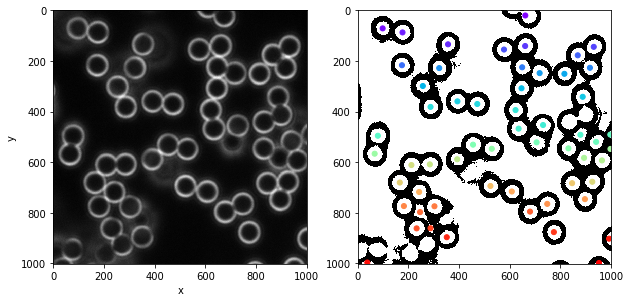

57


In [38]:
threshold=2800
start_time = time.time()  
spots = pd.DataFrame()
k=0
i = 0
for i, image in enumerate(images):
    processed_image = image > threshold  # threshold image
    processed_image = invert(processed_image)
    label_image = skimage.measure.label(processed_image)
    m=0
    for region in skimage.measure.regionprops(label_image, intensity_image=image):
        if region.area < 30 or region.area > 5000: # do not add spot
            continue
        spots = spots.append([{'y': region.centroid[0],
                               'x': region.centroid[1],
                               'area': region.area,
                               'frame': i,
                               'number': m,
                               'point': k}])
        m+=1;k+=1
spotstest=spots
findframe = 0
length = 1

newspots = np.zeros((len(spotstest),6))
dtype = [('x', float), ('y', float), ('area', int), ('frame', int), ('number', int), ('point', int)]
k=0
processed_image = images[frame] > threshold  # threshold image
processed_image = invert(processed_image)
label_image = skimage.measure.label(processed_image)
m=0
for region in skimage.measure.regionprops(label_image, intensity_image=image):
    if region.area < 30 or region.area > 5000: # do not add spot
        continue
    newspots[k,0]=round(region.centroid[1],4)
    newspots[k,1]=round(region.centroid[0],4)
    newspots[k,2]=int(region.area)
    newspots[k,3]=int(i)    #frame
    newspots[k,4]=int(m)    # of particle found
    newspots[k,5]=int(k)    #durchlaufende nummer
        
    m+=1;k+=1
        
part=max(spotstest['number'])+1
#colorwave = cm.rainbow(np.linspace(0, 1, part));radiusparticle=10
colorwave = cm.rainbow(np.linspace(0, 1, len(newspots)));radiusparticle=10;counter=0
for frame in range(findframe,findframe+length):
    processed_image = images[frame] > threshold  # threshold image
    processed_image = invert(processed_image)
    fig=plt.figure(1, figsize = (10,5))
    ax =plt.subplot(1, 2, 1)
    plt.imshow(images[frame], cmap='gray');
    plt.xlabel('x')
    plt.ylabel('y')
    ax =plt.subplot(1, 2, 2)
    plt.imshow(processed_image, cmap='gray');
      
    print(frame)
    for i in range(len(newspots)):
        circletwo = plt.Circle((newspots[i,0],newspots[i,1]), radius=radiusparticle, color=colorwave[i])  
        ax.add_artist(circletwo)
    plt.show()
    
print(max(spotstest['number'])+1)

1 px =  0.0308676778656 µm


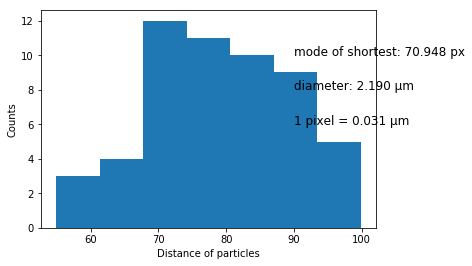

In [39]:
particles=np.zeros((m,2))
for i in range(m):
    particles[i,0]=newspots[i,0]
    particles[i,1]=newspots[i,1]
    
realparticle=m
connections = int(realparticle*(realparticle-1)/2)
distance = np.zeros(connections);distance[:]=np.nan
#timewave = np.linspace(0,dt*maxlength,maxlength)
real=[]
num1=0;num2=1
for j in range(connections):
    distance[j]=math.sqrt((particles[num1,0]-particles[num2,0])**2+(particles[num1,1]-particles[num2,1])**2)
    if distance[j]<100:
        real.append(distance[j])
    num2+=1
    if num2>realparticle-1:
        num1+=1
        num2=num1+1 

n, bins, patches = matplotlib.pyplot.hist(real,bins='auto')
for i in range(len(n)):
    if max(n)==n[i]:
        value = (bins[i]+bins[i+1])/2
        
print('1 px = ',particlesize/value,'µm')
plt.ylabel('Counts')
plt.xlabel('Distance of particles')
plt.text(90,10,'mode of shortest: {:.3f} px'.format(value),fontsize=12)
plt.text(90,8,'diameter: {:.3f} µm'.format(particlesize),fontsize=12)
plt.text(90,6,'1 pixel = {:.3f} µm'.format(particlesize/value ),fontsize=12)
plt.savefig('Histoshort.pdf', format='pdf')
plt.show()

#n, bins, patches = matplotlib.pyplot.hist(distance,bins='auto')
#plt.show()

***Ende***
-------------